# Dynamics

One of the objectives of tyssue is to make it easy to define and change the expression of the epithelium's energy. 
For this, we define two classes of objects:

- `Effector` : those define a single energy term, evaluated on the mesh, and depending on the values in the dataframe. For example, line tension, for which the energy is proportional to the length of the half-edge, is defined as an `Effector` object (see bellow). For each effector, we define a way to compute the energy and its spatial derivative, the gradient.

- `Model` : a model is basically a collection of effectors, with the mechanisms to combine them to define the total dynamics of the system.

In general, the parameters of the models are addressable at the single element level. For example, the line tension can be set for each individual edge.



In [2]:
import sys
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

from scipy import optimize

from tyssue import Sheet, config
from tyssue import SheetGeometry as geom
from tyssue.dynamics import effectors, model_factory
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import plot_forces
from tyssue.io import hdf5


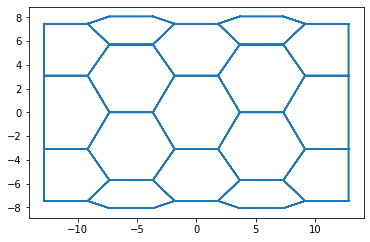

In [3]:
h5store = 'data/small_hexagonal.hf5'
#h5store = 'data/before_apoptosis.hf5'

datasets = hdf5.load_datasets(h5store)
sheet = Sheet('emin', datasets)
sheet.sanitize(trim_borders=True, order_edges=True)

geom.update_all(sheet)

geom.scale(sheet, 1/sheet.face_df['area']**0.5 )

fig, ax = sheet_view(sheet, ['z', 'x'], mode='quick')

### (Non)-Dimensionalization


If you read Farhadifar's article or other modeling papers, you'll see that the discussion on parameter values is done by  defining unit dimensions, e.g. the unit length is defined such that the preferred area is unity. This can be done by defining dimension-less parameters and scaling them to correspond to the geometry (for example, line tension, which as units of energy per unit length, has a factor of $\sqrt(A_0)$ between its dimension-less and its dimentionalized values. But in general it is simpler, and more robust computationally to scale the epithelium so that the average area is around unity (it is not strictly equivalent, but usually good enough), and then working with dimension-less units. 

Comparison with the real tissue can then be done by homothetically scaling length to match e.g. average junction lengths between experiments and models.



In [37]:
geom.scale(sheet, 1/sheet.face_df['area'].mean()**0.5, coords=sheet.coords)
geom.update_all(sheet)


## Effector classes

An effector designates a dynamical term in the epithelium governing equation. For quasistatic models, we need to provide  a method to compute the energy associated with this effector, and the corresponding gradient. 

For example, we can consider a line tension effector. The energy is $E_t = \sum_{ij} \Lambda\ell_{ij}$ where the sum is over all the edges. For each half-edge, the gradient of $E_t$ is defined by two terms, one for the gradient term associated with the half-edge ${ij}$ source, the over for it's target. For the $x$ coordinate:
$$
\frac{\partial E_t}{\partial x_i}
= \Lambda\left(\sum_k \frac{\partial \ell_{ik}}{\partial x_i} + \sum_m \frac{\partial \ell_{mi}}{\partial x_i}\right)
= \Lambda\left(\sum_k \frac{x_i}{\ell_{ik}}  - \sum_m \frac{x_i}{\ell_{mi}}\right)
$$

Where $\sum_k$ is are over all the edges which vertex $i$ is a source, and $\sum_m$ over all the edges of which vertex i is a target. 


Here is the definition of the line tension effector:
```python
class LineTension(AbstractEffector):

    dimensions = units.line_tension
    magnitude = "line_tension"
    label = "Line tension"
    element = "edge"
    specs = {"edge": {"is_active": 1, "line_tension": 1e-2}}

    spatial_ref = "mean_length", units.length

    @staticmethod
    def energy(eptm):
        return eptm.edge_df.eval(
            "line_tension" "* is_active" "* length / 2"
        )  # accounts for half edges

    @staticmethod
    def gradient(eptm):
        grad_srce = -eptm.edge_df[eptm.ucoords] * to_nd(
            eptm.edge_df.eval("line_tension * is_active/2"), len(eptm.coords)
        )
        grad_srce.columns = ["g" + u for u in eptm.coords]
        grad_trgt = -grad_srce
        return grad_srce, grad_trgt
```




### Predefined effectors

`AbstractEffector` : The abstract base class for all effectors

### Edge effectors

`LineTension` : $\Lambda \ell_{ij}$

`LengthElasticity` : $\frac{K_\ell}{2} (\ell_{ij} - \ell_0)^2$


### Face effectors

`SurfaceTension` : $S A_{\alpha}$

`PerimeterElasticity` : $\frac{K_P}{2} (P_{\alpha} - P_0)^2$

`FaceAreaElasticity` : $\frac{K_a}{2} (a_{\alpha} - a_0)^2$

`FaceVolumeElasticity` : $\frac{K_v}{2} (V_{\alpha} - V_0)^2$ (Volume is computed with the "height" column of the face.

`FaceContractility` : $\Gamma P_{\alpha}^2$

### Cell effectors

`CellAreaElasticity` : $\frac{K_A}{2} (A_C - A_0)^2$

`CellVolumeElasticity` : $\frac{K_V}{2} (V_C - V_0)^2$

### Lumen effectors (for closed geometries)

`LumenAreaElasticity` : $\frac{K_L}{2} (A_L - A_{L0})^2$

`LumenVolumeElasticity` : $\frac{K_L}{2} (V_L - V_{L0})^2$


(There are some more in the `effectors` module but they are less generally useful)


## Model factory


These effectors are then aggregated with others to define a `model` object. This object will have two methods `compute_energy` and `compute_gradient` that take an `Epithelium` object as single argument.

Such a model will usually be built with the function `model_factory`, that takes a list of effectors as input and returns a `model` object. For example, we can define the model from Farhadifar et al; by:


In [38]:
model = model_factory([
    effectors.LineTension,
    effectors.FaceContractility,
    effectors.FaceAreaElasticity
])


As for other aspects, the parameters are defined by a nested dictionary `spec`. Default values are gathered in the `model.spec` attribute:

In [39]:
model.specs

{'cell': {},
 'face': {'is_alive': 1,
  'perimeter': 1.0,
  'contractility': 1.0,
  'area': 1.0,
  'area_elasticity': 1.0,
  'prefered_area': 1.0},
 'edge': {'is_active': 1,
  'line_tension': 1.0,
  'sub_area': 0.16666666666666666},
 'vert': {},
 'settings': {'nrj_norm_factor': 1.0}}

We can use `sheet.update_spec` to set the correct columns in the sheet object.


Once the columns are set, it is possible to sets parameters for a subsets of edges (here by indexing the edges with a boolean series):
```
sheet.edge_df.loc[sheet.edge_df['sx']<0, 'line_tension'] = 0.5
```

In [40]:
sheet.update_specs(model.specs, reset=True)

Reseting column is_alive of the face dataset with new specs
Reseting column perimeter of the face dataset with new specs
Reseting column contractility of the face dataset with new specs
Reseting column area of the face dataset with new specs
Reseting column area_elasticity of the face dataset with new specs
Reseting column prefered_area of the face dataset with new specs
Reseting column is_active of the edge dataset with new specs
Reseting column line_tension of the edge dataset with new specs
Reseting column sub_area of the edge dataset with new specs


### Compute Energy

We now can compute the energy. By default, the `compute_energy` method returns a scalar, the total energy in the epithelium:

In [41]:
geom.update_all(sheet)
energy = model.compute_energy(sheet)
print(f'Total energy: {energy: .3f}')

Total energy:  364.185


We can compute all the energy terms with the `full_output=True`:

In [42]:
Et, Ec, Ea = model.compute_energy(sheet, full_output=True)

In [43]:
Et.head()

edge
0    0.323769
1    0.323769
2    0.322213
3    0.322213
4    0.322213
dtype: float64

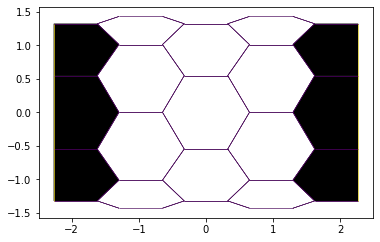

In [44]:
fig, ax = sheet_view(
    sheet,
    coords=list('zy'),
    face={"visible": True, "color": Ec, "colormap": "gray"},
    edge={"color": Et},
)

### Computing the gradient



Similarly, by default, the gradient computes an array of shape (Nv, 3), with 3 coordinates (or 2 in 2D) for each vertex.



In [45]:

grad_E = model.compute_gradient(sheet)

grad_E.head()

,gx,gy,gz
srce,,,
0,2.931605,1.214310e+00,-8.234192
1,2.931605,-1.214310e+00,-8.234192
2,2.640334,-1.093662e+00,-0.337580
3,2.892299,-1.007527e-14,-0.254173
4,2.640334,1.093662e+00,-0.337580


With `components=True` it returns a tuple of terms for each effector of the model.

In [46]:
gradients = model.compute_gradient(sheet, components=True)
gradients = {label: (srce, trgt) for label, (srce, trgt)
             in zip(model.labels, gradients)}
gradients['Line tension'][0].head()

,gx,gy,gz
edge,,,
0,-0.00000,-0.000000,-0.500000
1,-0.00000,-0.000000,0.500000
2,0.08434,0.424007,0.251207
3,-0.08434,0.424007,-0.251207
4,0.08434,-0.424007,0.251207


## Plotting forces

The `tyssue.draw` defines a useful `plot_forces` function:

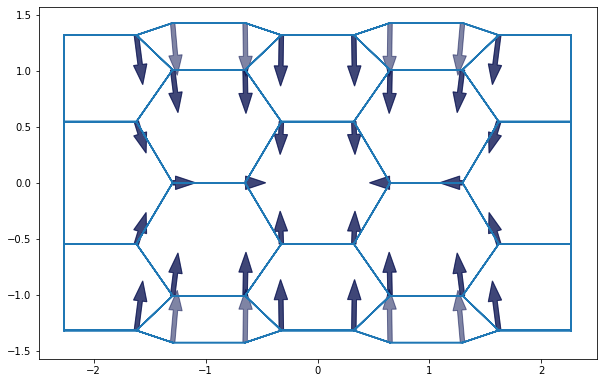

In [48]:
fig, ax = plot_forces(sheet, geom, model, ['z', 'y'], scaling=0.1)
fig.set_size_inches(10, 12)


### Fixing vertices


You may notice that the border vertices have no arrow. This is because they are not active, and do not participate in e.g. energy minimization, as we'll see in the next section.